<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Арсений Кравченко, DS team lead @ Juno. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №6
## <center> Исследование признаков на примере поездок такси в Чикаго

Чтобы начать работу, нужно скачать данные о поездках на такси в Чикаго за первые три месяца 2016 года, а также файл `column_remapping.json` и положить их в папку `data` в репозитории (комитить эти файлы не рекомендуется – они немаленькие).

Данные доступны на Kaggle в [этом](https://www.kaggle.com/chicago/chicago-taxi-rides-2016) соревновании. Описание данных [тут](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1yQkyn-FoutHi5BzSHq_YVNdN6ZGJe6za4y018nAi5UM).

In [1]:
RANDOM_STATE = 42
N_FOLDS = 5

In [2]:
import json
from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Будем играть с предсказанием цены, `fare` будет целевой переменной, тогда `trip_total` является ликом по отношению к ней – выкинем этот признак.

In [3]:
dataset_files = sorted(glob('../../data/chicago_taxi_trips_2016_*.csv'))
assert len(dataset_files) == 3

df = pd.concat(map(pd.read_csv, dataset_files))
df.drop('trip_total', axis=1, inplace=True)
target = df.pop('fare')

Загрузим словарь, ключи которого – названия признаков, а значения – опять же, словари, отображающие индексы уникальных значений признака в сами значения. Если звучит путано, посмотрите, например, на признак `pickup_longitude` в исходных данных и в словаре `column_remapping`.

In [4]:
with open('../../data/column_remapping.json') as json_file:
    column_remapping = json.load(json_file)

In [5]:
df.head()

taxi_id trip_start_timestamp  trip_end_timestamp  trip_seconds  trip_miles  \
0     85.0   2016-1-13 06:15:00  2016-1-13 06:15:00         180.0        0.40   
1   2776.0   2016-1-22 09:30:00  2016-1-22 09:45:00         240.0        0.70   
2   3168.0   2016-1-31 21:30:00  2016-1-31 21:30:00           0.0        0.00   
3   4237.0   2016-1-23 17:30:00  2016-1-23 17:30:00         480.0        1.10   
4   5710.0   2016-1-14 05:45:00  2016-1-14 06:00:00         480.0        2.71   

   pickup_census_tract  dropoff_census_tract  pickup_community_area  \
0                  NaN                   NaN                   24.0   
1                  NaN                   NaN                    NaN   
2                  NaN                   NaN                    NaN   
3                  NaN                   NaN                    6.0   
4                  NaN                   NaN                   32.0   

   dropoff_community_area  tips  tolls  extras payment_type  company  \
0                    24.0  0.00    0.0     0.0         Cash    107.0   
1                     NaN  4.45    0.0     0.0  Credit Card      NaN   
2                     NaN  5.00    0.0     0.0  Credit Card    119.0   
3                     6.0  0.00    0.0     0.0         Cash      NaN   
4                     NaN  0.00    0.0     0.0         Cash      NaN   

   pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude  
0            199.0             510.0             199.0              510.0  
1              NaN               NaN               NaN                NaN  
2              NaN               NaN               NaN                NaN  
3            686.0             500.0             686.0              500.0  
4            385.0             478.0               NaN                NaN

In [6]:
assert df.shape == (5432105, 18)

**<font color='red'>Вопрос №1.</font> Какой из признаков является вещественным и из предобработки требует только заполнения/удаления пропусков? **

- dropoff_latitude
- <font color='red'>tips</font>
- company
- pickup_census_tract

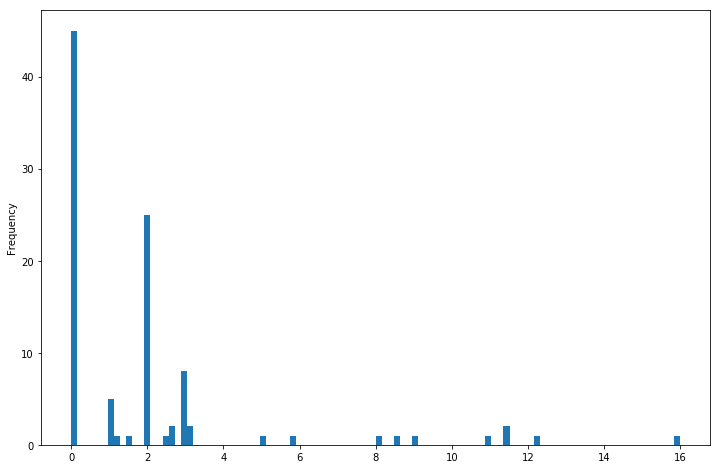

In [7]:
ddd = df['tips']
ddd.sample(100, random_state=RANDOM_STATE).plot(kind='hist', bins=100)

**<font color='red'>Вопрос №2.</font> Какие методы предобработки целевой переменной могут быть уместны, судя по графику? **

- возведение в n-ую степень, n >= 2 
- ride2vec
- <font color='red'>логарифмирование</font>
- никакие

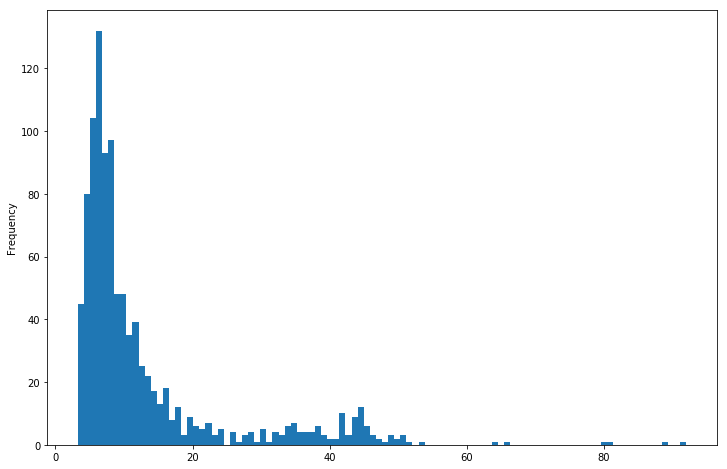

In [8]:
target.sample(1000, random_state=RANDOM_STATE).plot(kind='hist', bins=100);

**<font color='red'>Вопрос №3.</font> Каково максимальное расстояние (`great-circle distance` из библиотеки `geopy`, в км) между точками `pickup` и `dropoff`?** <br>(Для ускорения подсчета можно использовать `joblib`)
- 27.23
- 19.91
- 23.52
- 43.66

In [9]:
pickup_dropoff = df[['pickup_latitude', 'pickup_longitude', 
                     'dropoff_latitude', 'dropoff_longitude']].dropna()

In [10]:
# def great_circle_distance(lat1, lng1, lat2, lng2):   
#     #переводим градусы в радианы
#     pi80 = 3.141592653589793 / 180
#     lat1 = lat1*pi80
#     lng1 = lng1*pi80
#     lat2 = lat2*pi80
#     lng2 = lng2*pi80

#     r = 6372.795; # радиус земли в км
#     #Счиатем разницу между широтой и долготой.
#     dlat = lat2 - lat1
#     dlng = lng2 - lng1
    
#     #вычисления длины большого круга
#     a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(lat1) * np.cos(lat2) * np.sin(dlng / 2) * np.sin(dlng / 2)
#     c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#     km = r * c
#     return km

In [15]:
#pip install geopy
from geopy.distance import vincenty
#newport_ri = (41.49008, -71.312796)
#cleveland_oh = (41.499498, -81.695391)
#print(vincenty(newport_ri, cleveland_oh).miles

In [16]:
for row in df.itertuples():
    print(row)

Pandas(Index=0, taxi_id=85.0, trip_start_timestamp='2016-1-13 06:15:00', trip_end_timestamp='2016-1-13 06:15:00', trip_seconds=180.0, trip_miles=0.40000000000000002, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=24.0, dropoff_community_area=24.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=107.0, pickup_latitude=199.0, pickup_longitude=510.0, dropoff_latitude=199.0, dropoff_longitude=510.0)
Pandas(Index=1, taxi_id=2776.0, trip_start_timestamp='2016-1-22 09:30:00', trip_end_timestamp='2016-1-22 09:45:00', trip_seconds=240.0, trip_miles=0.69999999999999996, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=nan, dropoff_community_area=nan, tips=4.4500000000000002, tolls=0.0, extras=0.0, payment_type='Credit Card', company=nan, pickup_latitude=nan, pickup_longitude=nan, dropoff_latitude=nan, dropoff_longitude=nan)
Pandas(Index=2, taxi_id=3168.0, trip_start_timestamp='2016-1-31 21:30:00', trip_end_timestamp='2016-1-31 21:30

Pandas(Index=987, taxi_id=7725.0, trip_start_timestamp='2016-1-24 17:00:00', trip_end_timestamp='2016-1-24 17:45:00', trip_seconds=1920.0, trip_miles=16.899999999999999, pickup_census_tract=nan, dropoff_census_tract=911.0, pickup_community_area=8.0, dropoff_community_area=8.0, tips=9.1500000000000004, tolls=0.0, extras=4.0, payment_type='Credit Card', company=nan, pickup_latitude=419.0, pickup_longitude=615.0, dropoff_latitude=688.0, dropoff_longitude=206.0)
Pandas(Index=988, taxi_id=5820.0, trip_start_timestamp='2016-1-23 18:15:00', trip_end_timestamp='2016-1-23 18:15:00', trip_seconds=540.0, trip_miles=1.5, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=4.0, dropoff_community_area=4.0, tips=2.0, tolls=0.0, extras=1.0, payment_type='Credit Card', company=nan, pickup_latitude=399.0, pickup_longitude=780.0, dropoff_latitude=399.0, dropoff_longitude=780.0)
Pandas(Index=989, taxi_id=5668.0, trip_start_timestamp='2016-1-5 15:45:00', trip_end_timestamp='2016-1-5 15

Pandas(Index=2076, taxi_id=1736.0, trip_start_timestamp='2016-1-22 09:15:00', trip_end_timestamp='2016-1-22 09:15:00', trip_seconds=0.0, trip_miles=0.0, pickup_census_tract=nan, dropoff_census_tract=787.0, pickup_community_area=8.0, dropoff_community_area=8.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=8.0, pickup_latitude=161.0, pickup_longitude=649.0, dropoff_latitude=161.0, dropoff_longitude=649.0)
Pandas(Index=2077, taxi_id=279.0, trip_start_timestamp='2016-1-9 10:15:00', trip_end_timestamp='2016-1-9 10:30:00', trip_seconds=660.0, trip_miles=0.0, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=8.0, dropoff_community_area=6.0, tips=6.0, tolls=0.0, extras=1.5, payment_type='Credit Card', company=8.0, pickup_latitude=599.0, pickup_longitude=346.0, dropoff_latitude=686.0, dropoff_longitude=500.0)
Pandas(Index=2078, taxi_id=6865.0, trip_start_timestamp='2016-1-16 19:00:00', trip_end_timestamp='2016-1-16 19:15:00', trip_seconds=900.0, trip_mile

Pandas(Index=3787, taxi_id=7005.0, trip_start_timestamp='2016-1-8 16:45:00', trip_end_timestamp='2016-1-8 17:00:00', trip_seconds=420.0, trip_miles=1.5, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=77.0, dropoff_community_area=2.0, tips=0.0, tolls=0.0, extras=1.0, payment_type='Cash', company=nan, pickup_latitude=556.0, pickup_longitude=288.0, dropoff_latitude=684.0, dropoff_longitude=503.0)
Pandas(Index=3788, taxi_id=1149.0, trip_start_timestamp='2016-1-15 22:00:00', trip_end_timestamp='2016-1-15 22:15:00', trip_seconds=720.0, trip_miles=0.20000000000000001, pickup_census_tract=nan, dropoff_census_tract=607.0, pickup_community_area=33.0, dropoff_community_area=8.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=107.0, pickup_latitude=584.0, pickup_longitude=60.0, dropoff_latitude=767.0, dropoff_longitude=733.0)
Pandas(Index=3789, taxi_id=4499.0, trip_start_timestamp='2016-1-9 10:00:00', trip_end_timestamp='2016-1-9 10:00:00', trip_seconds=0.0

Pandas(Index=5036, taxi_id=1703.0, trip_start_timestamp='2016-1-24 16:45:00', trip_end_timestamp='2016-1-24 17:15:00', trip_seconds=1680.0, trip_miles=1.1000000000000001, pickup_census_tract=nan, dropoff_census_tract=313.0, pickup_community_area=32.0, dropoff_community_area=76.0, tips=0.0, tolls=0.0, extras=4.0, payment_type='Cash', company=107.0, pickup_latitude=744.0, pickup_longitude=605.0, dropoff_latitude=225.0, dropoff_longitude=6.0)
Pandas(Index=5037, taxi_id=3316.0, trip_start_timestamp='2016-1-12 01:00:00', trip_end_timestamp='2016-1-12 01:30:00', trip_seconds=1620.0, trip_miles=18.5, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=76.0, dropoff_community_area=nan, tips=6.0, tolls=0.0, extras=31.0, payment_type='Credit Card', company=92.0, pickup_latitude=225.0, pickup_longitude=6.0, dropoff_latitude=nan, dropoff_longitude=nan)
Pandas(Index=5038, taxi_id=2862.0, trip_start_timestamp='2016-1-25 16:00:00', trip_end_timestamp='2016-1-25 16:45:00', trip_se

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.



Pandas(Index=18526, taxi_id=4601.0, trip_start_timestamp='2016-1-21 20:30:00', trip_end_timestamp='2016-1-21 20:30:00', trip_seconds=180.0, trip_miles=0.90000000000000002, pickup_census_tract=nan, dropoff_census_tract=749.0, pickup_community_area=28.0, dropoff_community_area=28.0, tips=2.0, tolls=0.0, extras=1.0, payment_type='Credit Card', company=101.0, pickup_latitude=411.0, pickup_longitude=545.0, dropoff_latitude=681.0, dropoff_longitude=196.0)
Pandas(Index=18527, taxi_id=6300.0, trip_start_timestamp='2016-1-6 16:30:00', trip_end_timestamp='2016-1-6 17:00:00', trip_seconds=1560.0, trip_miles=0.0, pickup_census_tract=nan, dropoff_census_tract=807.0, pickup_community_area=28.0, dropoff_community_area=28.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=8.0, pickup_latitude=411.0, pickup_longitude=545.0, dropoff_latitude=411.0, dropoff_longitude=545.0)
Pandas(Index=18528, taxi_id=7785.0, trip_start_timestamp='2016-1-29 23:15:00', trip_end_timestamp='2016-1-29 23:30:00

Pandas(Index=19562, taxi_id=2702.0, trip_start_timestamp='2016-1-6 14:30:00', trip_end_timestamp='2016-1-6 14:45:00', trip_seconds=480.0, trip_miles=1.8, pickup_census_tract=nan, dropoff_census_tract=342.0, pickup_community_area=8.0, dropoff_community_area=7.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=92.0, pickup_latitude=474.0, pickup_longitude=204.0, dropoff_latitude=725.0, dropoff_longitude=518.0)
Pandas(Index=19563, taxi_id=1924.0, trip_start_timestamp='2016-1-14 18:45:00', trip_end_timestamp='2016-1-14 18:45:00', trip_seconds=540.0, trip_miles=0.0, pickup_census_tract=nan, dropoff_census_tract=40.0, pickup_community_area=32.0, dropoff_community_area=28.0, tips=1.5, tolls=0.0, extras=0.0, payment_type='Credit Card', company=107.0, pickup_latitude=744.0, pickup_longitude=605.0, dropoff_latitude=395.0, dropoff_longitude=408.0)
Pandas(Index=19564, taxi_id=5807.0, trip_start_timestamp='2016-1-9 22:15:00', trip_end_timestamp='2016-1-9 22:15:00', trip_seconds=480.0,

Pandas(Index=20653, taxi_id=8589.0, trip_start_timestamp='2016-1-13 14:00:00', trip_end_timestamp='2016-1-13 14:00:00', trip_seconds=120.0, trip_miles=0.29999999999999999, pickup_census_tract=nan, dropoff_census_tract=16.0, pickup_community_area=32.0, dropoff_community_area=32.0, tips=0.0, tolls=0.0, extras=1.0, payment_type='Cash', company=107.0, pickup_latitude=18.0, pickup_longitude=610.0, dropoff_latitude=18.0, dropoff_longitude=610.0)
Pandas(Index=20654, taxi_id=6042.0, trip_start_timestamp='2016-1-18 13:45:00', trip_end_timestamp='2016-1-18 14:00:00', trip_seconds=600.0, trip_miles=4.5999999999999996, pickup_census_tract=nan, dropoff_census_tract=970.0, pickup_community_area=6.0, dropoff_community_area=8.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=10.0, pickup_latitude=355.0, pickup_longitude=333.0, dropoff_latitude=210.0, dropoff_longitude=470.0)
Pandas(Index=20655, taxi_id=4891.0, trip_start_timestamp='2016-1-25 02:45:00', trip_end_timestamp='2016-1-25 03:0

Pandas(Index=22025, taxi_id=5812.0, trip_start_timestamp='2016-1-11 14:15:00', trip_end_timestamp='2016-1-11 14:15:00', trip_seconds=300.0, trip_miles=0.0, pickup_census_tract=nan, dropoff_census_tract=16.0, pickup_community_area=32.0, dropoff_community_area=32.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=8.0, pickup_latitude=18.0, pickup_longitude=610.0, dropoff_latitude=18.0, dropoff_longitude=610.0)
Pandas(Index=22026, taxi_id=3766.0, trip_start_timestamp='2016-1-7 21:30:00', trip_end_timestamp='2016-1-7 21:30:00', trip_seconds=0.0, trip_miles=0.0, pickup_census_tract=nan, dropoff_census_tract=749.0, pickup_community_area=28.0, dropoff_community_area=28.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=nan, pickup_latitude=681.0, pickup_longitude=196.0, dropoff_latitude=681.0, dropoff_longitude=196.0)
Pandas(Index=22027, taxi_id=4765.0, trip_start_timestamp='2016-1-12 03:00:00', trip_end_timestamp='2016-1-12 03:00:00', trip_seconds=0.0, trip_miles=

Pandas(Index=22686, taxi_id=7292.0, trip_start_timestamp='2016-1-2 14:00:00', trip_end_timestamp='2016-1-2 14:00:00', trip_seconds=0.0, trip_miles=0.0, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=nan, dropoff_community_area=nan, tips=2.0, tolls=0.0, extras=0.0, payment_type='Credit Card', company=119.0, pickup_latitude=nan, pickup_longitude=nan, dropoff_latitude=nan, dropoff_longitude=nan)
Pandas(Index=22687, taxi_id=1079.0, trip_start_timestamp='2016-1-5 09:30:00', trip_end_timestamp='2016-1-5 09:30:00', trip_seconds=360.0, trip_miles=0.90000000000000002, pickup_census_tract=nan, dropoff_census_tract=16.0, pickup_community_area=8.0, dropoff_community_area=32.0, tips=1.0, tolls=0.0, extras=1.0, payment_type='Credit Card', company=nan, pickup_latitude=419.0, pickup_longitude=615.0, dropoff_latitude=18.0, dropoff_longitude=610.0)
Pandas(Index=22688, taxi_id=7860.0, trip_start_timestamp='2016-1-5 16:00:00', trip_end_timestamp='2016-1-5 16:00:00', trip_seconds=

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Pandas(Index=35467, taxi_id=8302.0, trip_start_timestamp='2016-1-4 20:45:00', trip_end_timestamp='2016-1-4 20:45:00', trip_seconds=120.0, trip_miles=0.59999999999999998, pickup_census_tract=nan, dropoff_census_tract=911.0, pickup_community_area=32.0, dropoff_community_area=8.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=109.0, pickup_latitude=744.0, pickup_longitude=605.0, dropoff_latitude=688.0, dropoff_longitude=206.0)
Pandas(Index=35468, taxi_id=1611.0, trip_start_timestamp='2016-1-29 12:15:00', trip_end_timestamp='2016-1-29 12:30:00', trip_seconds=660.0, trip_miles=2.2999999999999998, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=nan, dropoff_community_area=nan, tips=2.0499999999999998, tolls=0.0, extras=1.0, payment_type='Credit Card', company=109.0, pickup_latitude=nan, pickup_longitude=nan, dropoff_latitude=nan, dropoff_longitude=nan)
Pandas(Index=35469, taxi_id=8739.0, trip_start_timestamp='2016-1-9 15:00:00', trip_end_timestamp='20

Pandas(Index=37148, taxi_id=3614.0, trip_start_timestamp='2016-1-29 12:15:00', trip_end_timestamp='2016-1-29 12:30:00', trip_seconds=600.0, trip_miles=1.6000000000000001, pickup_census_tract=nan, dropoff_census_tract=959.0, pickup_community_area=28.0, dropoff_community_area=8.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=92.0, pickup_latitude=411.0, pickup_longitude=545.0, dropoff_latitude=167.0, dropoff_longitude=754.0)
Pandas(Index=37149, taxi_id=6474.0, trip_start_timestamp='2016-1-22 15:30:00', trip_end_timestamp='2016-1-22 16:00:00', trip_seconds=1560.0, trip_miles=20.5, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=76.0, dropoff_community_area=nan, tips=15.0, tolls=0.0, extras=32.0, payment_type='Credit Card', company=107.0, pickup_latitude=575.0, pickup_longitude=547.0, dropoff_latitude=nan, dropoff_longitude=nan)
Pandas(Index=37150, taxi_id=3675.0, trip_start_timestamp='2016-1-23 21:45:00', trip_end_timestamp='2016-1-23 22:00:00', t

Pandas(Index=38095, taxi_id=8280.0, trip_start_timestamp='2016-1-1 00:30:00', trip_end_timestamp='2016-1-1 00:45:00', trip_seconds=360.0, trip_miles=0.0, pickup_census_tract=nan, dropoff_census_tract=534.0, pickup_community_area=8.0, dropoff_community_area=8.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=107.0, pickup_latitude=695.0, pickup_longitude=366.0, dropoff_latitude=454.0, dropoff_longitude=453.0)
Pandas(Index=38096, taxi_id=4705.0, trip_start_timestamp='2016-1-25 19:45:00', trip_end_timestamp='2016-1-25 20:00:00', trip_seconds=660.0, trip_miles=2.1000000000000001, pickup_census_tract=nan, dropoff_census_tract=911.0, pickup_community_area=32.0, dropoff_community_area=8.0, tips=0.0, tolls=0.0, extras=1.0, payment_type='Cash', company=107.0, pickup_latitude=30.0, pickup_longitude=405.0, dropoff_latitude=688.0, dropoff_longitude=206.0)
Pandas(Index=38097, taxi_id=7676.0, trip_start_timestamp='2016-1-13 13:15:00', trip_end_timestamp='2016-1-13 13:30:00', trip_seco

Pandas(Index=39193, taxi_id=5187.0, trip_start_timestamp='2016-1-22 16:45:00', trip_end_timestamp='2016-1-22 16:45:00', trip_seconds=540.0, trip_miles=1.3999999999999999, pickup_census_tract=nan, dropoff_census_tract=534.0, pickup_community_area=8.0, dropoff_community_area=8.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=107.0, pickup_latitude=210.0, pickup_longitude=470.0, dropoff_latitude=454.0, dropoff_longitude=453.0)
Pandas(Index=39194, taxi_id=3461.0, trip_start_timestamp='2016-1-17 11:30:00', trip_end_timestamp='2016-1-17 11:45:00', trip_seconds=360.0, trip_miles=0.0, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=77.0, dropoff_community_area=3.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=8.0, pickup_latitude=556.0, pickup_longitude=288.0, dropoff_latitude=660.0, dropoff_longitude=120.0)
Pandas(Index=39195, taxi_id=6742.0, trip_start_timestamp='2016-1-20 11:00:00', trip_end_timestamp='2016-1-20 11:00:00', trip_secon

Pandas(Index=40230, taxi_id=8470.0, trip_start_timestamp='2016-1-27 00:00:00', trip_end_timestamp='2016-1-27 00:15:00', trip_seconds=480.0, trip_miles=2.2000000000000002, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=22.0, dropoff_community_area=24.0, tips=0.0, tolls=0.0, extras=1.0, payment_type='Cash', company=107.0, pickup_latitude=604.0, pickup_longitude=668.0, dropoff_latitude=199.0, dropoff_longitude=510.0)
Pandas(Index=40231, taxi_id=7555.0, trip_start_timestamp='2016-1-14 22:00:00', trip_end_timestamp='2016-1-14 22:15:00', trip_seconds=720.0, trip_miles=5.5999999999999996, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=32.0, dropoff_community_area=6.0, tips=3.5499999999999998, tolls=0.0, extras=0.0, payment_type='Credit Card', company=107.0, pickup_latitude=385.0, pickup_longitude=478.0, dropoff_latitude=686.0, dropoff_longitude=500.0)
Pandas(Index=40232, taxi_id=685.0, trip_start_timestamp='2016-1-4 20:30:00', trip_end_times

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.



Pandas(Index=54605, taxi_id=5723.0, trip_start_timestamp='2016-1-25 16:45:00', trip_end_timestamp='2016-1-25 17:00:00', trip_seconds=300.0, trip_miles=1.0, pickup_census_tract=nan, dropoff_census_tract=334.0, pickup_community_area=8.0, dropoff_community_area=8.0, tips=2.0, tolls=0.0, extras=0.0, payment_type='Credit Card', company=107.0, pickup_latitude=218.0, pickup_longitude=437.0, dropoff_latitude=294.0, dropoff_longitude=113.0)
Pandas(Index=54606, taxi_id=8681.0, trip_start_timestamp='2016-1-22 22:30:00', trip_end_timestamp='2016-1-22 22:30:00', trip_seconds=420.0, trip_miles=0.0, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=41.0, dropoff_community_area=40.0, tips=0.0, tolls=0.0, extras=0.0, payment_type='Cash', company=107.0, pickup_latitude=583.0, pickup_longitude=195.0, dropoff_latitude=301.0, dropoff_longitude=156.0)
Pandas(Index=54607, taxi_id=1832.0, trip_start_timestamp='2016-1-20 19:15:00', trip_end_timestamp='2016-1-20 19:15:00', trip_seconds=3

Pandas(Index=55951, taxi_id=2537.0, trip_start_timestamp='2016-1-14 13:30:00', trip_end_timestamp='2016-1-14 13:30:00', trip_seconds=0.0, trip_miles=0.0, pickup_census_tract=nan, dropoff_census_tract=nan, pickup_community_area=nan, dropoff_community_area=nan, tips=1.3, tolls=0.0, extras=0.0, payment_type='Credit Card', company=119.0, pickup_latitude=nan, pickup_longitude=nan, dropoff_latitude=nan, dropoff_longitude=nan)
Pandas(Index=55952, taxi_id=22.0, trip_start_timestamp='2016-1-24 15:30:00', trip_end_timestamp='2016-1-24 15:30:00', trip_seconds=300.0, trip_miles=0.90000000000000002, pickup_census_tract=nan, dropoff_census_tract=225.0, pickup_community_area=8.0, dropoff_community_area=8.0, tips=0.0, tolls=0.0, extras=1.5, payment_type='Cash', company=107.0, pickup_latitude=419.0, pickup_longitude=615.0, dropoff_latitude=754.0, dropoff_longitude=410.0)
Pandas(Index=55953, taxi_id=5018.0, trip_start_timestamp='2016-1-18 12:45:00', trip_end_timestamp='2016-1-18 13:00:00', trip_seconds=

KeyboardInterrupt: 

Давайте обучим простую модель, прежде чем пробовать добавлять признаки.

In [9]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    y_data = target.fillna(0)
    
kfold = KFold(n_splits=N_FOLDS, shuffle=True)
# np.abs тут нужен,т.к. sklearn по ошибке возвращает отрицательную MSE
print(np.abs(cross_val_score(LinearRegression(), 
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error')\
    .mean()))

926.729562741
CPU times: user 9.22 s, sys: 2.87 s, total: 12.1 s
Wall time: 8.74 s


**<font color='red'>Вопрос №4.</font> В ячейке выше допущено несколько ошибок и неаккуратных действий.
Что из перечисленных НЕ является проблемой, влияющей на настоящее качество модели? **

- <font color='red'>не зафиксирован random seed</font>
- признаки разной размерности не нормированы
- взята малая подвыборка признаков
- пропуски в целевой переменной заполнены неуместным значением по умолчанию

Слегка модифицируем обработку данных.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

877.7118181861897

**<font color='red'>Вопрос №5.</font> Какой из признаков нужно убрать, чтобы качество модели улучшилось значительнее всего?**

- tips
- tolls 
- trip_seconds
- trip_miles
- <font color='red'>ни один из вышеперечисленных</font>

Давайте построим модель на двух признаках (время поездки и пройденное расстояние) и попробуем добавить еще один признак, связанный с датой. 

In [11]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['trip_start_timestamp', 'trip_seconds', 'trip_miles']]
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

timestamp = pd.to_datetime(X_data.pop('trip_start_timestamp'))

t1 = timestamp.apply(lambda x: x.dayofweek)
t2 = timestamp.apply(lambda x: 1 if x.dayofweek in (5, 6) else 0)
t3 = timestamp.apply(lambda x: x.hour)
t4 = timestamp.apply(lambda x: x.dayofweek * 24 + x.hour)

CPU times: user 1min 17s, sys: 2.67 s, total: 1min 20s
Wall time: 1min 20s


In [12]:
for i, t in enumerate((t1, t2, t3, t4)):
    X_data_changed = X_data.copy()
    X_data_changed['time'] = t
    
    # Ваш код здесь

** <font color='red'>Вопрос №6.</font> Какие выводы можно сделать? **

- новые признаки не улучшают модель, т.к. автор намеренно совершил техническую ошибку
- новые признаки не улучшают модель, т.к. такова природа данных
- <font color='red'>новые признаки улучшают модель всего на 3%</font>
- новые признаки улучшают модель всего на 7%

** <font color='red'>Вопрос №7</font>. Отвлечемся и пофантазируем. Представим, что ввели закон, обязывающий пассажиров такси фотографировать своего водителя перед каждой поездкой и после каждой поездки; к нам, в дополнение к текущему датасету, попали эти фотографии. Как _нельзя_ было бы использовать их в предсказании цены поездки? **

-  <font color='red'>извлечь признаки водителя при помощи предобученной нейронной сети, получив значения на одном из последних полносвязных слоев</font>
- использовать метаданные о модели телефона пассажира
- использовать геотег с обеих фотографий
- использовать время съемки

Давайте попробуем преобразовать один из признаков, чтобы избавиться от "длинного хвоста" справа.

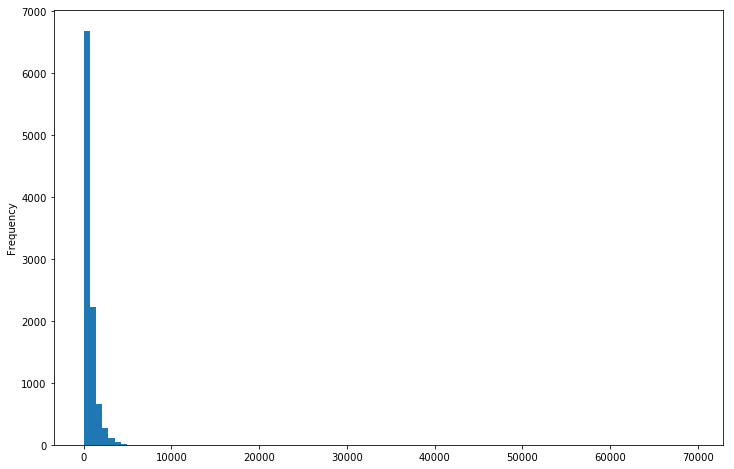

In [13]:
df_tmp = df.copy()
df_tmp = df_tmp[df_tmp.trip_seconds > 0]
seconds = df_tmp.trip_seconds

seconds.sample(10000).plot(kind='hist', bins=100);

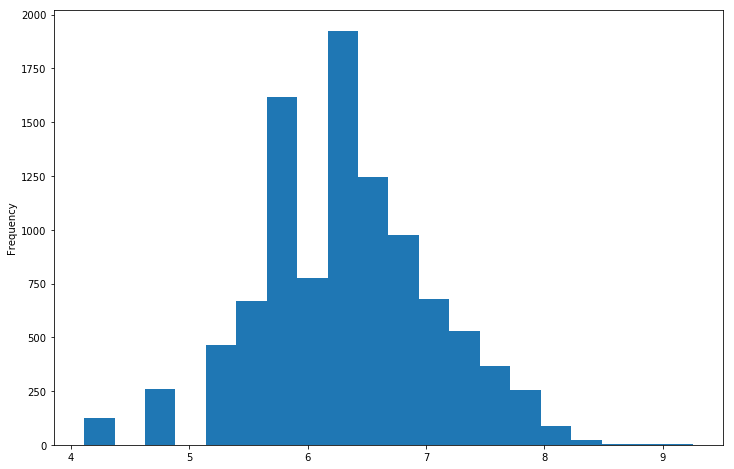

In [14]:
seconds.sample(10000).apply(lambda x: 
                            np.log(x + 1)).plot(kind='hist', bins=20);

**<font color='red'>Вопрос №8.</font> Зачем в предыдущей ячейке используется `np.log(x + 1)`, а не просто `np.log`?**

- чтобы запутать читателей
- чтобы получить бимодальное распределение
- для скорости вычисления
- <font color='red'>во избежание `ValueError`</font>